In [1]:
import logging
import psycopg2
import itertools

from heapq import merge
from itertools import groupby
from operator import itemgetter

from collections import Counter

def fetch(dbname, user, host, password, query):
    '''
    Executes query on a given database
    '''
    connection_string = "dbname='{0}' user='{1}' host='{2}' password='{3}'".format(
        dbname, user, host, password)
    try:
        conn = psycopg2.connect(connection_string)
        curr = conn.cursor()
        curr.execute(query)
        res = curr.fetchall()
    except Exception as e:
        print(e)
        logging.exception('')
    finally:
        curr.close()
        conn.close()
        
    return res

def inner_join(a, b):
    '''
    Joins two iterables of tuples on the first 
    element
    
    Arguments:
    a - list of tuples (id, x)
    b - list of tuples (id, y)
    
    Returns:
    list of tuples (id, x, y)
    '''
    key = itemgetter(0)
    a.sort(key=key) 
    b.sort(key=key)
    for _, group in groupby(merge(a, b, key=key), key):
        row_a, row_b = next(group), next(group, None)
        if row_b is not None: # join
            yield row_a + row_b[1:]
            

def filter_videos(videos, min_count = 10):
    '''
    Filters videos and returns mapping to the original tags
    
    Returns:
    filtered       - a list with transformed and filtered videos
    tags_2_indices - a dictinary that transforms tags to rank of their
                     frequencies
    indices_2_tags - inverse dictionary
    '''
    
    # we have to iterate twice, first to create dictionary, then 
    # then to filter tags and transform the list
    if not isinstance(videos, list):
        videos = list(videos)
        
    # Filters top tags and creates mapping
    count = Counter(itertools.chain(*[tup[1] for tup in videos]))
    tags_2_indices = { 
        tag_id: index 
            for index, (tag_id, count) in enumerate(count.most_common(), 1)
            if count >= min_count 
    }

    # reverse index for decoding 
    indices_2_tags = { 
        v: k for k, v in tags_2_indices.items()
    }

    filtered = []
    for video_id, tags, url in videos:
        encoded = [tags_2_indices[t] for t in tags if t in tags_2_indices]
        if encoded:
            filtered.append((video_id, encoded, url))
                
    return filtered, tags_2_indices, indices_2_tags

## Videos data

In [2]:
dbname='ds-wizards'
user='wizard'
host='192.95.32.117'
password='GaG23jVxZhMnQaU53r8o'

VQUERY = "select post_id, url from videos where status='ok'"

In [3]:
vres = fetch(dbname, user, host, password, VQUERY)
vres = [(post_id.split("_")[1], url) for post_id, url in vres]

## Tags

In [4]:
dbname='ds-content-tags'
user='ds-content-tags'
password='0fXjWl592vNf1gYvIw8w'
host='192.95.32.117'

TQUERY = "select id, tags from videos where tags is not NULL"
TAGS = "select tag_id, name, path from content_tags"

In [5]:
tres = fetch(dbname, user, host, password, TQUERY)

In [6]:
tags = { 
    tag_id: (name, path) for (tag_id, name, path) in fetch(
        dbname, user, host, password, TAGS) 
}

## Join videos with tags

In [7]:
videos = inner_join(tres, vres)

In [8]:
filtered, t2i, i2t = filter_videos(videos, 10)

In [9]:
print("Found %d videos with %d unique tags" % (len(filtered), len(t2i)))

Found 9644 videos with 477 unique tags


In [10]:
import random

In [11]:
video_id, video_tags,  video_path = random.choice(filtered)

## Extract features

In [12]:
from t1000.embedding import video

In [13]:
frames = video.extract_frames(video_path)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

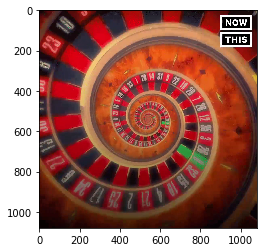

In [15]:
plt.imshow(frames[5])

In [16]:
print(" \n".join([tags[i2t[tag]][0] for tag in video_tags]))

Las Vegas
